<a href="https://colab.research.google.com/github/nkolln/DataChallenge1/blob/master/Reupload_visualisation_%2B_confusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
import itertools
import multiprocessing.pool
import threading
from functools import partial

import keras
import pandas as pd
from keras import backend as K
from keras import layers, models
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.backend import relu, sigmoid
import numpy as np
import time

import tensorflow as tf
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import utils
from tensorflow.python.saved_model import tag_constants, signature_constants
from tensorflow.python.saved_model.signature_def_utils_impl import build_signature_def, predict_signature_def
from tensorflow.contrib.session_bundle import exporter
import os


def model_fn(labels_dim):
    """Create a Keras Sequential model with layers."""

    model = models.Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(128, 128, 3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(labels_dim, activation='softmax', kernel_initializer='glorot_uniform'))

    compile_model(model)
    return model


def compile_model(model):
    opt = keras.optimizers.Adagrad(lr=0.01)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

def read_train_data():
    start_time = time.time()
    print("Start Read Train Data")
    data = np.load("trainDataSmall.npz")
    #data = np.load("/content/drive/My Drive/Colab Notebooks/trainDataSmall.npz")
    print("Train data read --- %s seconds ---" % (time.time() - start_time))
    X_train = data["X_train"]
    Y_train = data["Y_train"]
    print("Training - Total examples per class", np.sum(Y_train, axis=0))
    return [X_train, Y_train]


def read_test_data():
    start_time = time.time()
    print("Start Read Test Data")
    data = np.load("testDataSmall.npz")
    #data = np.load("/content/drive/My Drive/Colab Notebooks/testDataSmall.npz")
    print("Test data read --- %s seconds ---" % (time.time() - start_time))
    X_test = data["X_test"]
    Y_test = data["Y_test"]
    print("Testing - Total examples per class", np.sum(Y_test, axis=0))
    return [X_test, Y_test]


Using TensorFlow backend.


In [0]:
"""This code implements a Feed forward neural network using Keras API."""

%tensorflow_version 1.x
import argparse
import glob
import json
import os
import numpy as np

import keras
import tensorflow as tf
from keras.models import load_model
from tensorflow.python.lib.io import file_io
from keras.preprocessing.image import ImageDataGenerator

CLASS_SIZE = 5
FILE_PATH = 'checkpoint.{epoch:02d}.hdf5'
RETINOPATHY_MODEL = 'retinopathy.hdf5'

class ContinuousEval(keras.callbacks.Callback):
    """Continuous eval callback to evaluate the checkpoint once
       every so many epochs.
    """

    def __init__(self,
                 eval_frequency,
                 job_dir):
        self.eval_frequency = eval_frequency
        self.job_dir = job_dir
        [self.X_test, self.Y_test] = read_test_data()

    def on_epoch_begin(self, epoch, logs={}):
        if epoch > 0 and epoch % self.eval_frequency == 0:
            # Unhappy hack to work around h5py not being able to write to GCS.
            # Force snapshots and saves to local filesystem, then copy them over to GCS.
            model_path_glob = 'checkpoint.*'
            model_path_glob = os.path.join(self.job_dir, model_path_glob)
            checkpoints = glob.glob(model_path_glob)
            if len(checkpoints) > 0:
                checkpoints.sort()
                retinopathy_model = load_model(checkpoints[-1])
                retinopathy_model = compile_model(retinopathy_model)
                loss, acc = retinopathy_model.evaluate(
                    self.X_test, self.Y_test)
                print('\nEvaluation epoch[{}] metrics[{:.2f}, {:.2f}] {}'.format(
                    epoch, loss, acc, retinopathy_model.metrics_names))
            else:
                print('\nEvaluation epoch[{}] (no checkpoints found)'.format(epoch))


def run():
    tf.keras.backend.clear_session()
    #local dir to write checkpoints and export model
    job_dir = 'jobdir'
    #Batch size for training steps
    train_batch_size = 40
    #Maximum number of epochs on which to train
    num_epochs = 20
    #Checkpoint per n training epochs
    checkpoint_epochs = 5
    #Perform one evaluation per n epochs
    eval_frequency = 5

    retinopathy_model = model_fn(CLASS_SIZE)

    try:
        os.makedirs(job_dir)
    except:
        pass

    # Unhappy hack to work around h5py not being able to write to GCS.
    # Force snapshots and saves to local filesystem, then copy them over to GCS.
    checkpoint_path = FILE_PATH
    checkpoint_path = os.path.join(job_dir, checkpoint_path)

    # Model checkpoint callback
    checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        verbose=2,
        period=checkpoint_epochs,
        mode='max')

    # Continuous eval callback
    evaluation = ContinuousEval(eval_frequency,
                                job_dir)

    # Tensorboard logs callback
    tblog = keras.callbacks.TensorBoard(
        log_dir=os.path.join(job_dir, 'logs'),
        histogram_freq=0,
        write_graph=True,
        embeddings_freq=0)

    callbacks = [checkpoint, evaluation, tblog]

    [X_train, Y_train] = read_train_data()

    datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)

    retinopathy_model.fit_generator(
        datagen.flow(X_train, Y_train, batch_size=train_batch_size),
        steps_per_epoch=100,
        epochs=num_epochs,
        callbacks=callbacks,
        verbose=2,
        validation_data=(evaluation.X_test, evaluation.Y_test))

    retinopathy_model.save(os.path.join(job_dir, RETINOPATHY_MODEL))



In [3]:
#from google.colab import drive
#drive.mount('/content/drive') ## If you want to read from your drive - this is not required, as you can get the files as below, but it might faster

## this will download the data from the internet, it may fail if the server is not up
![ -f testDataSmall.npz ] || wget -O testDataSmall.npz "https://www.win.tue.nl/~cdecampos/testDataSmall.npz"
![ -f trainDataSmall.npz ] || wget -O trainDataSmall.npz "https://www.win.tue.nl/~cdecampos/trainDataSmall.npz"
!rm -fr jobdir/

run()


#drive.flush_and_unmount() ## if you need to unmount your google drive

--2019-12-09 23:21:48--  https://www.win.tue.nl/~cdecampos/testDataSmall.npz
Resolving www.win.tue.nl (www.win.tue.nl)... 131.155.11.13
Connecting to www.win.tue.nl (www.win.tue.nl)|131.155.11.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101034899 (96M) [text/plain]
Saving to: ‘testDataSmall.npz’

testDataSmall.npz   100%[===================>]  96.35M   114MB/s    in 0.8s    

2019-12-09 23:21:49 (114 MB/s) - ‘testDataSmall.npz’ saved [101034899/101034899]

--2019-12-09 23:21:51--  https://www.win.tue.nl/~cdecampos/trainDataSmall.npz
Resolving www.win.tue.nl (www.win.tue.nl)... 131.155.11.13
Connecting to www.win.tue.nl (www.win.tue.nl)|131.155.11.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203493642 (194M) [text/plain]
Saving to: ‘trainDataSmall.npz’

trainDataSmall.npz  100%[===================>] 194.07M  91.6MB/s    in 2.1s    

2019-12-09 23:21:53 (91.6 MB/s) - ‘trainDataSmall.npz’ saved [203493642/203493642]





Ins

In [0]:
from matplotlib import pyplot as plt
from numpy import loadtxt
from keras.models import load_model

model = load_model('jobdir/retinopathy.hdf5')

data = np.load("testDataSmall.npz")
X_test = data["X_test"]
Y_test = data["Y_test"]

yProbTest = model.predict_proba(X_test)
yClassTest = model.predict_classes(X_test)



Enter number of the test case: 356
Predicted Class = 1, Actuall Class = 0


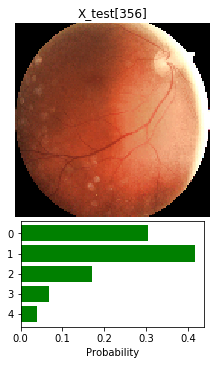

In [6]:
def convert_act(yInput):
  if(yInput == [1, 0, 0, 0, 0]).all():
    return 0
  elif(yInput == [0, 1, 0, 0, 0]).all():
    return 1
  elif(yInput == [0, 0, 1, 0, 0]).all():
    return 2
  elif(yInput == [0, 0, 0, 1, 0]).all():
    return 3
  elif(yInput == [0, 0, 0, 0, 1]).all():
    return 4

val = input("Enter number of the test case: ") 

imgToShow = tf.keras.preprocessing.image.array_to_img(
    X_test[int(val)],
    data_format=None,
    scale=True,
    dtype=None
)

fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)

ax1.axis('off')
ax1.set_title("X_test[%s]" % (val))
ax1.imshow(imgToShow)
    
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([0,1,2,3,4])
ax2.set_xlabel('Probability')
ax2.invert_yaxis()
ax2.barh(y_pos, yProbTest[int(val)], xerr=0, align='center', color='green')

print("Predicted Class = %s, Actuall Class = %s" % (yClassTest[int(val)], convert_act(Y_test[int(val)])))
plt.show()

In [7]:
%matplotlib
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt


Using matplotlib backend: agg


In [0]:
new_Y_test = []

for x in range(len(Y_test)):
  new_Y_test.append(convert_act(Y_test[x]))

In [0]:
cm = confusion_matrix(new_Y_test, yClassTest)

In [0]:
#https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


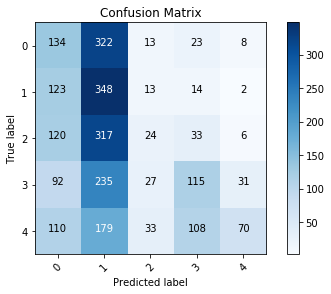

In [11]:
cm_plot_labels = [0, 1, 2, 3, 4]
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')